In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random

# Create Job

In [2]:
job_time_interval = np.random.poisson(5,99)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)
print(len(job_create_time))

[ 2  3  3  1  4  7 12  3  7  6  9  2  4  5  5  3  5  3  4  4  5  5  4  6
  3  3  4  3  4  7  6  4  7  5  8  2 10  4  5  4  6  5  7  4  8  3  6  7
  5  2  2  3  5  9  7  4  3  7  6  3  4  6  2  8  5  1  5  3  5  7  2  3
  9  4  3  8  6  6  6  2  2  5  3  4  8  8  7  3  4  8  5  4  2  6  4  5
  7  4  7]
[0, 2, 5, 8, 9, 13, 20, 32, 35, 42, 48, 57, 59, 63, 68, 73, 76, 81, 84, 88, 92, 97, 102, 106, 112, 115, 118, 122, 125, 129, 136, 142, 146, 153, 158, 166, 168, 178, 182, 187, 191, 197, 202, 209, 213, 221, 224, 230, 237, 242, 244, 246, 249, 254, 263, 270, 274, 277, 284, 290, 293, 297, 303, 305, 313, 318, 319, 324, 327, 332, 339, 341, 344, 353, 357, 360, 368, 374, 380, 386, 388, 390, 395, 398, 402, 410, 418, 425, 428, 432, 440, 445, 449, 451, 457, 461, 466, 473, 477, 484]
100


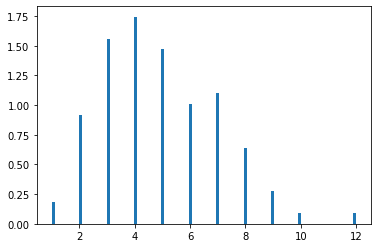

In [3]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

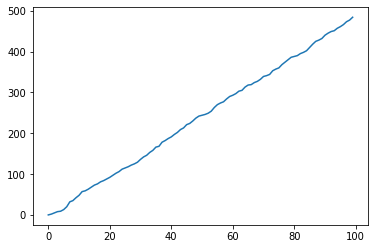

In [4]:
plt.plot(job_create_time)
plt.show()

# Job Queue

In [5]:
class JobQueue(object):
    
    def __init__(self):
        self.job_q = queue.Queue()
        self.job_number = 0
        
    def insertJob(self, inout,  station_dest):
        job = {"inout": inout, "station_dest": station_dest}
        self.job_q.put(job)
        self.job_number+=1

    def getJob(self):
        if self.job_q.empty():
            return 
        self.job_number-=1
        return self.job_q.get()

In [6]:
def job_create(rack_location,job_create_time,jobQ,total_job_location_list):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        jobQ.insertJob("in",job_location)
    else:
        jobQ.insertJob("out",job_location)
    total_job_location_list.append(job_location)
    return jobQ

# Auction

In [7]:
class Auction():
    def __init__(self,job,available_agv):
        self.job = job 
        self.available_agv = available_agv
        
    def choose_auctioneer(self,auction_agv_list):
        if len(auction_agv_list) == 0:
            self.auctioneer = random.choice(available_agv)
        
    def select_agv(self,bidding_list):
        self.bidding_list = bidding_list
        min_bid = min(biddling_list)
        target_agv = available_agv.index(min_bid)
        return target_agv
    

# AGV

In [28]:
class AGV(object):
    max_battery = 1000
    CHARGING_STATION = [(2,9),(6,9)]    
    
    def __init__(self,agv_id,current_location,current_tick=0):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick
    
    def move_one_tick(self):
        self.next_location = self.path[0]
        self.current_location = self.next_location
        del self.path[0]
        self.battery -=1
        self.current_tick +=1
    
    def get_job(self,job,astar_path):
        self.job = job
        self.path = astar_path
        self.available = False
    
    def calculate_cost(self,agv_id,job,warehouse,INPUT_STATION,OUTPUT_STATION):
        if job['inout']=='in':
            cost = len(astar(warehouse,agv.current_location,INPUT_STATION))
        else:
            cost = len(astar(warehouse,agv.current_location,Rack_enterence[job['station_dest']]))
        return cost        
    
    def job_release(self):
        self.available = True

In [29]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold]

# Astar

In [30]:
class node:
    def __init__(self,parent=None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,other):
        return self.position == other.position

In [31]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node[0]-goal_node[0])
    dy = abs(start_node[1]-goal_node[1])
    return dx + dy

In [32]:
def astar(graph,start,goal):
    start_node = node(None,(start[1],start[0]))
    goal_node = node(None,(goal[1],goal[0]))
    open_list = []
    closed_list = []
    graph = [el for el in graph][::-1]
#     for i in graph:
#         print(i)
    
    open_list.append(start_node)
    while open_list:
        current_node = open_list[0]
        current_index = 0
        
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        if current_node == goal_node:
            path = []
            current = current_node
            while current is not None:
#                 x,y = current.position
#                 graph[x][y] = 9
                path.append((current.position[1],current.position[0]))
                current = current.parent
                
            return path[::-1]
        
        children = []
        for new_position in [(0,1),(1,0),(-1,0),(0,-1)]:
            node_position = (current_node.position[0]+new_position[0],
                             current_node.position[1]+new_position[1])
            within_range = [
                node_position[1]>len(graph)-1,
                node_position[1]<0,
                node_position[0]>len(graph[len(graph)-1])-1,
                node_position[0]<0]
            if any(within_range):
                continue
            if graph[node_position[0]][node_position[1]] !=0:
                continue
            
            new_node = node(current_node, node_position)
            children.append(new_node)
        
        for child in children:
            if child in closed_list:
                continue
            child.g = current_node.g+1
            child.h = manhattan_distance(child.position,goal_node.position)
            child.f = child.g + child.h
            
            if len([open_node for open_node in open_list
                   if child == open_node and child.g>open_node.g]) > 0:
                continue
            open_list.append(child)
            

# Warehouse, Rack

In [33]:
def make_warehouse(row,col):
    warehouse = [[0]*col for i in range(row)]
    return warehouse 

In [34]:
def set_rack(warehouse,rack_location):
    for idx, row in enumerate(warehouse):
        warehouse[idx] =  [1 if (ix, ROW -1 - idx) in rack_location else 0 for ix,col in enumerate(warehouse[idx])]

In [35]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

## Make Warehouse, Rack, Rack enterence, Station

In [36]:
ROW, COL = 10,10
battery_threshold = 200
warehouse = make_warehouse(ROW,COL)

In [37]:
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]

set_rack(warehouse,rack_location)

In [38]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

In [39]:
INPUT_STATION = (3,0)
OUTPUT_STATION = (6,0)

# 실험

In [40]:
jobQ = JobQueue()
total_job_location_list = []

In [41]:
agv1 = AGV("agv1",(0,9))
agv2 = AGV("agv2",(3,9))
agv3 = AGV("agv3",(6,9))
agv4 = AGV("agv4",(9,9))
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

In [42]:
jobQ.insertJob("in",(1,1))
jobQ.insertJob("out",(1,2))
jobQ.insertJob("in",(1,1))
jobQ.insertJob("out",(1,3))

In [43]:
avail = getAvailAGV(AGV_LIST,battery_threshold)
print(avail)

[<__main__.AGV object at 0x0000027D7E8272C8>, <__main__.AGV object at 0x0000027D7E827188>, <__main__.AGV object at 0x0000027D7E827488>, <__main__.AGV object at 0x0000027D7E8273C8>]


In [44]:
job = jobQ.getJob()
bidding_list=[]
for agv in avail:
    bidding_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
print(bidding_list)
    

[13, 10, 13, 16]


# Main 함수

In [45]:
print(job_create_time)

[0, 2, 5, 8, 9, 13, 20, 32, 35, 42, 48, 57, 59, 63, 68, 73, 76, 81, 84, 88, 92, 97, 102, 106, 112, 115, 118, 122, 125, 129, 136, 142, 146, 153, 158, 166, 168, 178, 182, 187, 191, 197, 202, 209, 213, 221, 224, 230, 237, 242, 244, 246, 249, 254, 263, 270, 274, 277, 284, 290, 293, 297, 303, 305, 313, 318, 319, 324, 327, 332, 339, 341, 344, 353, 357, 360, 368, 374, 380, 386, 388, 390, 395, 398, 402, 410, 418, 425, 428, 432, 440, 445, 449, 451, 457, 461, 466, 473, 477, 484]


In [46]:
jobQ = JobQueue()
run_time = 15
total_job_location_list = []
select_agv = []

In [47]:
for time in range(run_time+1):
    if time in job_create_time:
        job_create(rack_location,job_create_time,jobQ,total_job_location_list)
    agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
    if len(agv_avail)!=0 and jobQ.job_number !=0:
        if time ==0:
            auctioneer = random.choice(agv_avail)
        else:
            auctioneer = select_agv[-1]
        job = jobQ.getJob()
        print(job)
        bid_list = []
        for agv in agv_avail:
            bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
        min_bid = min(bid_list)
        target_agv = agv_avail[bid_list.index(min_bid)]
        if job['inout']=='in':
            astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)
        else:
            astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])
        target_agv.get_job(job,astar_path)
        select_agv.append(target_agv)
        target_agv.move_one_tick()
        print(target_agv)
        print(auctioneer)

{'inout': 'in', 'station_dest': [(8, 4)]}
{'inout': 'in', 'station_dest': [(4, 3)]}
{'inout': 'in', 'station_dest': [(2, 5)]}
{'inout': 'in', 'station_dest': [(5, 5)]}
